# Tidal flow and vegetation interactions

*(modified from Greg Tucker, August 2020)*

This tutorial explains how the `TidalFlowCalculator` Landlab component can be combined with a range of vegetation modeling approaches to describe salt marsh dynamics. We will start with the simplest vegetation formulation and then add complexity to see how the results change. Depending on the simulation temporal scale, sometimes the differences between vegetation modeling approaches may not affect the results but over time, the integrated ecogeomorphic dynamics become more pronounced and more sophisticated models of vegetation become necessary to capture the role of plants in the salt marsh system.

## Theory

The `TidalFlowCalculator` computes a tidal-cycle averaged flow velocity field, given a topography (bathymetry), mean sea level, tidal range, and tidal period. The approach that the component uses is based on Mariotti (2018). The idea is to calculate a flow velocity field that is just sufficient to bring in (flood tide) or send out (ebb tide) all of the water that enters or leaves the system during one tidal cycle. We will not discuss the numerical background of this component here. For more information, see the Tidal Flow Calculator Landlab tutorial.

In reality, tidal flow across a wetland landscape depends on the underlying bathymtery and roughness that is largely self-organized by ecological processes. Salt marsh environments are a mosaic of marsh plains, tidal channels, and unvegetated pools. The interaction of tides, waves, and storms and the resultant sediment transport which occur at temporal timescales on the order of seconds to hours interact with biogeochemical and ecological processes which occur at timescales on the order of days to years to form and maintain this unique ecotone.

# Creating the domain

First we will start with a simple gridded domain that consists of a flat marsh plain intersected by a single channel, identical to a case presented in the Tidal Flow Calculator tutorial. The first codeblocks import the libraries we will need and create our plotting functions.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

from landlab import RasterModelGrid, imshow_grid
from landlab.components import TidalFlowCalculator

In [2]:
from landlab.grid.mappers import map_link_vector_components_to_node


def map_velocity_components_to_nodes(grid):
    """Map the velocity components from the links to the nodes, and return the node arrays."""
    ebb_vel_x, ebb_vel_y = map_link_vector_components_to_node(
        grid, grid.at_link["ebb_tide_flow__velocity"]
    )
    flood_vel_x = -ebb_vel_x
    flood_vel_y = -ebb_vel_y
    return (ebb_vel_x, ebb_vel_y, flood_vel_x, flood_vel_y)


def plot_tidal_flow(grid, resample=1):
    (ebb_x, ebb_y, flood_x, flood_y) = map_velocity_components_to_nodes(grid)

    # depth
    plt.figure()
    imshow_grid(
        grid, grid.at_node["mean_water__depth"], cmap="YlGnBu", color_for_closed="g"
    )
    plt.title("Water depth (m)")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    # down-sample for legible quiver plots if needed
    if resample != 1:
        xr = grid.x_of_node.reshape(
            (grid.number_of_node_rows, grid.number_of_node_columns)
        )[::resample, ::resample]
        yr = grid.y_of_node.reshape(
            (grid.number_of_node_rows, grid.number_of_node_columns)
        )[::resample, ::resample]
        ebb_xr = ebb_x.reshape((grid.number_of_node_rows, grid.number_of_node_columns))[
            ::resample, ::resample
        ]
        ebb_yr = ebb_y.reshape((grid.number_of_node_rows, grid.number_of_node_columns))[
            ::resample, ::resample
        ]
        fld_xr = flood_x.reshape(
            (grid.number_of_node_rows, grid.number_of_node_columns)
        )[::resample, ::resample]
        fld_yr = flood_y.reshape(
            (grid.number_of_node_rows, grid.number_of_node_columns)
        )[::resample, ::resample]
    else:
        xr = grid.x_of_node
        yr = grid.y_of_node
        ebb_xr = ebb_x
        ebb_yr = ebb_y
        fld_xr = flood_x
        fld_yr = flood_y

    # ebb tide
    plt.figure()
    imshow_grid(grid, grid.at_node["topographic__elevation"])
    plt.quiver(xr, yr, ebb_xr, ebb_yr)
    plt.title("Ebb Tide")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    ebb_vel_magnitude = np.sqrt(ebb_x * ebb_x + ebb_y * ebb_y)
    plt.figure()
    imshow_grid(grid, ebb_vel_magnitude, cmap="magma", color_for_closed="g")
    plt.title("Ebb Tide Velocity Magnitude (m/s)")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    # flood tide
    plt.figure()
    imshow_grid(grid, grid.at_node["topographic__elevation"])
    plt.quiver(xr, yr, fld_xr, fld_yr)
    plt.title("Flood Tide")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    plt.figure()
    flood_vel_magnitude = np.sqrt(flood_x * flood_x + flood_y * flood_y)
    imshow_grid(grid, flood_vel_magnitude, cmap="magma", color_for_closed="g")
    plt.title("Flood Tide Velocity Magnitude (m/s)")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

In this example, vegetation is assumed to occur only on the marsh plain and is uniformly dense such that the Manning's roughness coefficient is equal to 0.2.

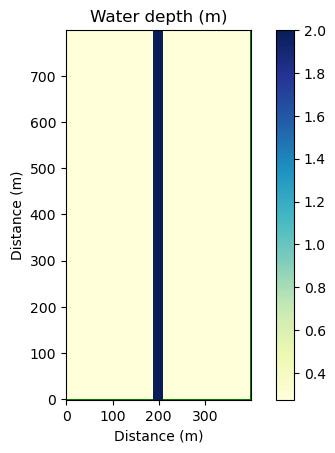

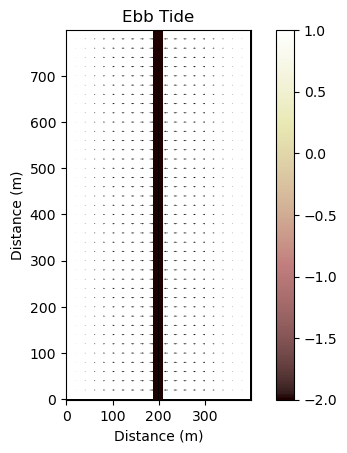

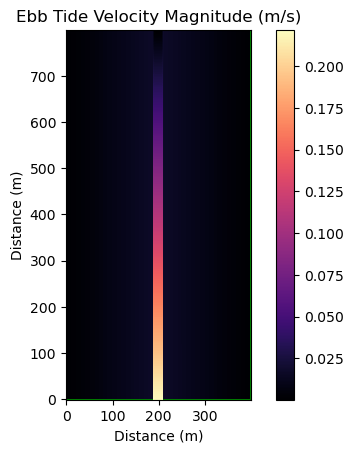

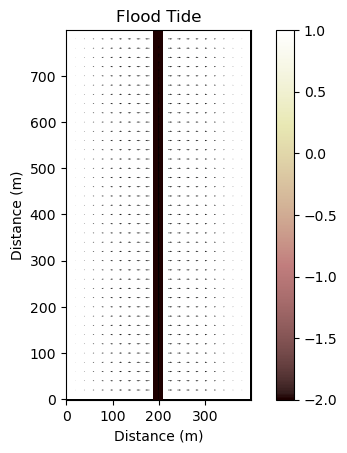

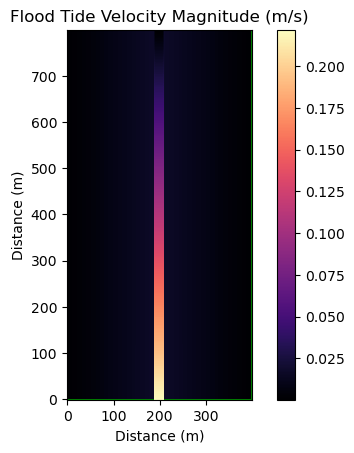

In [3]:
from landlab.grid.mappers import map_max_of_link_nodes_to_link

# parameters
nrows = 400
ncols = 200
grid_spacing = 2.0  # m
marsh_height = 1.0  # m
channel_depth = 2.0  # m
tidal_range = 3.1  # m
tidal_period = 12.5 * 3600.0  # s
open_nodes = np.arange(
    94, 105, dtype=int
)  # IDs of open-boundary nodes (along channel at bottom/south boundary)
roughness_shallow = 0.2  # Manning's n for areas above mean sea level (i.e., the marsh)
roughness_deep = 0.01  # Manning's n for areas below mean sea level (i.e., the channel)

# create and set up the grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=grid_spacing)
z = grid.add_zeros("topographic__elevation", at="node")
z[grid.core_nodes] = marsh_height
channel = np.logical_and(grid.x_of_node >= 188.0, grid.x_of_node <= 208.0)
z[channel] = -channel_depth
grid.set_closed_boundaries_at_grid_edges(True, True, True, True)
grid.status_at_node[open_nodes] = grid.BC_NODE_IS_FIXED_VALUE

# set up roughness field (calculate on nodes, then map to links)
roughness_at_nodes = roughness_shallow + np.zeros(z.size)
roughness_at_nodes[z < 0.0] = roughness_deep
roughness = grid.add_zeros("roughness", at="link")
map_max_of_link_nodes_to_link(grid, roughness_at_nodes, out=roughness)

# instantiate the TidalFlowCalculator
tfc = TidalFlowCalculator(
    grid, tidal_range=tidal_range, tidal_period=tidal_period, roughness="roughness"
)

# run it
tfc.run_one_step()

# make plots...
plot_tidal_flow(grid, resample=10)

This shows a snapshot of peak velocities at flood and ebb tide and the maximum depth of water at high tide. 

However, marsh plains are not uniformly flat and serve to connect to the uplands. Let's adjust our bathymetry to reflect a mild slope between the channel edge and the boundary.

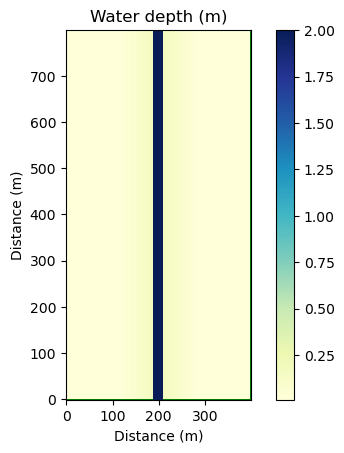

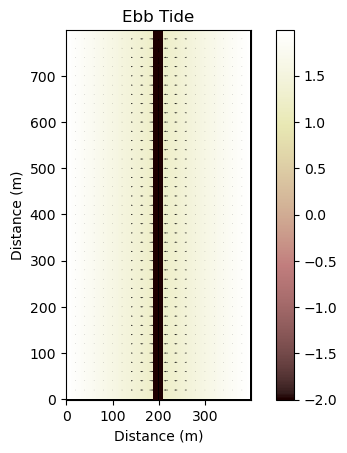

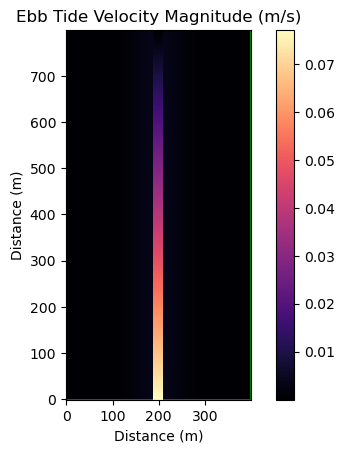

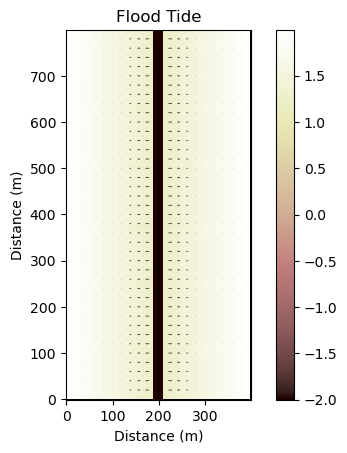

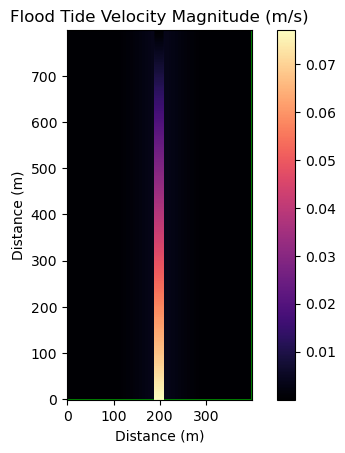

In [8]:
marsh_max_height = 2.0
marsh_min_height = 1.2
marsh_slope = (marsh_max_height - marsh_min_height)/(400 - 208)
z[grid.x_of_node < 188] = marsh_max_height - marsh_slope * grid.x_of_node[grid.x_of_node < 188]
z[grid.x_of_node > 208] = marsh_min_height + marsh_slope * (grid.x_of_node[grid.x_of_node > 208] - 208)

# instantiate the TidalFlowCalculator
tfc_slope = TidalFlowCalculator(
    grid, tidal_range=tidal_range, tidal_period=tidal_period, roughness="roughness"
)

# run it
tfc_slope.run_one_step()

# make plots...
plot_tidal_flow(grid, resample=10)

As you can see, adding a sloped marsh plain concentrates zone of measurable tidal velocity closer to the channel. However, the zone of greatest velocity remains in the channel. The maximum depth is increased closer to the channel but the change over one tidal cycle in subtle. In actuality, vegetation productivity on the marsh plain is strongly controlled by the inundation duration. In many simple ecogeomorphic marsh models, the relationship is described with a parabolic deterministic relationship between inundation and peak biomass. The peak biomass directly relates to the roughness.

First we need to calculate the inundation time per tidal period. This equation taken from Hickey et al 2019 and used by the Cohort Marsh Equilibrium Model is used to calculate the inundation time as a function of tidal datums and elevation.

In [12]:
#' Calculate flood time using trigonometric method
#'
#' This function calculates flood time in hours from an elevation, and a high and low tidal datum. 
#' @param z a numeric, elevation of the marsh
#' @param datumHigh a numeric, highest water level of the tidal period
#' @param datumLow a numeric, lowest water level of the tidal period
#' @param tidalCycleLength a numeric, the length of time of the tidal cycle. This is set to 1 so that it estimates fractional flood time
#' 
#' @references Hickey, R. (2019). Tidal inundation modeling within GIS. Journal of Coastal Conservation, 23(3), 599-606.
#' @references Department of the Navy. Hydrographic Branch. 1994. Australian National Tide Tables: Australia, Papua & New Guinea, Australian Hydrographic Publication 11.
#'  
#' @return a numeric, flood time per tidal period
#' @export
def floodTimeTrig(z, datum_high, datum_low, tidal_period = 1):
  
  # If elevation is above the tidal range indation time is 0
  datum_high[z>=datum_high] = z[z>=datum_high]
  
  # If elevation is below inundation time is a full tidal cycle
  datum_low[z<=datum_low] = z[z<=datum_low]
  
  # Rising time over cell = 6.21 (A/pi - 1)	
  # where A = 2* pi - cos-1 [2 (height of cell – meanLowWater) / (meanHighWater – meanLowWater) - 1] radians
  A1 = 2 * np.pi - np.arccos(2 * (z - datum_low) / (datum_high - datum_low) - 1)
  rising_time = tidal_period / 2 * (A1 / np.pi - 1)
  
  # Falling time over cell = 6.21 (A/pi - 1) where
  # A = 2* - cos-1 [2 (height of cell – meanHighWater) / (meanLowWater – meanHighWater) - 1] radians
  A2 = 2 * np.pi - np.arccos(2 * (z - datum_high) / (datum_low - datum_high) - 1)
  falling_time = tidal_period / 2 * (A2 / np.pi - 1)
  
  # If between inundation time = abs (time rising - 6.21) + time falling
  inundation_time = np.abs(rising_time - tidal_period/2) + falling_time
  
  return inundation_time

Here we use the grid and tidal flow component settings to calculate the inundation time across the grid for one tidal period. 

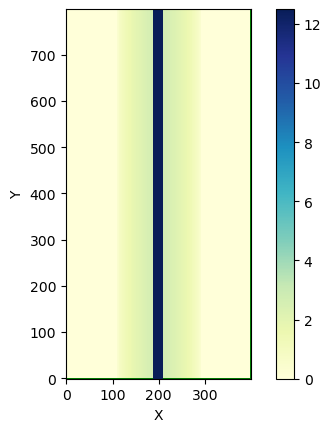

In [15]:
grid_inundation = floodTimeTrig(z, datum_high=tidal_range / 2 * np.ones_like(z), datum_low= -tidal_range / 2 * np.ones_like(z), tidal_period=tidal_period/3600)
plt.figure()
imshow_grid(
    grid, grid_inundation, cmap="YlGnBu", color_for_closed="g"
)

Using the deterministic relationship between biomass and annual inundation time, we can estimate the biomass and relate that back to roughness to demonstrate how vegetation roughness combines with bathymetry to influence tidal velocities.